# RHIRL [1]

In [1]:
import numpy as np
import tensorflow as tf
from rhirl import *

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

from rhirl_plotting import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

Defined using simple rl framework [3]

In [2]:
np.random.seed(1)
tf.set_random_seed(0)
goal_reward = 1.
obstacle_reward = -10.
E = 7
nvmdp_test_1 = NavigationMDP(width=E, 
                        height=1,
                        goal_locs=[(E,1)],
                        init_loc=(1,1),
                        additional_obstacles={0: [(E-1, 1)], 1: [(E-2, 1)], 2: [(E-3, 1)], 3: [(E-4, 1)], 4: [(E-5, 1)], 5: [(E-6, 1)]},
                        rand_init=True,
                        cell_types=["indigo", "blue", "green", "yellow", "orange", "red"],
                        cell_type_rewards=[-1, -1, -1, -1, -1, -1],
                        goal_reward=0.,
                        slip_prob=0.00,
                        step_cost=0, 
                        vacancy_prob=1.,
                        sample_cell_types=range(6),
                        use_goal_dist_feature=False,
                        goal_color="violet",
                        gamma=1.)

nvmdp_test_2 = NavigationMDP(width=7, 
                        height=7,
                        goal_locs=[(5,5)],
                        init_loc=(1,1),
                        rand_init=True,
                        cell_types=['white', 'yellow', 'red', 'lime', 'magenta'], #["white", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, obstacle_reward, obstacle_reward, obstacle_reward],
                        goal_reward=goal_reward,
                        slip_prob=0.00,
                        step_cost=0.2, 
                        vacancy_prob=.80,
                        gamma=.99)

nvmdp_orig = NavigationMDP(width=30, 
                        height=30,
                        goal_locs=[(21,21)],
                        init_loc=(1,1),
                        rand_init=True,
                        cell_types=['white', 'yellow', 'red', 'lime', 'magenta'],
                        cell_type_rewards=[0, 0, obstacle_reward, obstacle_reward, obstacle_reward],
                        goal_reward=goal_reward,
                        slip_prob=0.00,
                        step_cost=4, 
                        vacancy_prob=.85,
                        use_goal_dist_feature=True,
                        gamma=0.99)

nvmdp = nvmdp_orig
value_iter = ValueIteration(nvmdp, sample_rate=1)
_ = value_iter.run_vi()
v_objective_map = np.zeros((nvmdp.height, nvmdp.width), dtype=np.float32)
for row in range(nvmdp.height):
    for col in range(nvmdp.width):
        x, y = nvmdp._rowcol_to_xy(row, col)
        v_objective_map[row, col] = value_iter.value_func[GridWorldState(x, y)]

#### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

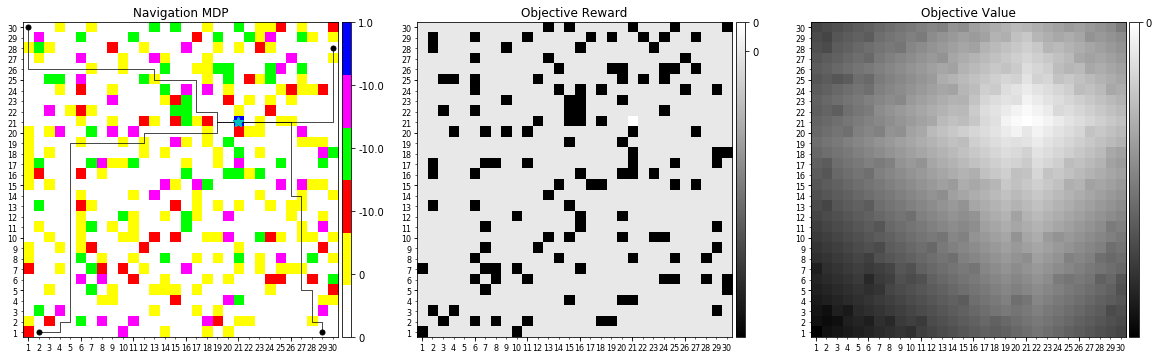

In [3]:
np.random.seed(0)
N_tau = 4
D_traj_states, D_traj_actions = nvmdp.sample_data(n_trajectory=N_tau, 
                                                    init_states=[GridWorldState(29,1), GridWorldState(1,30), GridWorldState(2,1), GridWorldState(30,28)], #GridWorldState(1,7)],
                                                    init_repetition=False, 
                                                    policy=value_iter.policy)
plt.figure(figsize=(20,14))
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
                     subplot_str="132", new_fig=False, show_rewards_cbar=True, cmap=plt.cm.gray, title="Objective Reward")
nvmdp.visualize_grid(v_objective_map, trajectories=None, 
                     subplot_str="133", new_fig=False, show_rewards_cbar=True, cmap=plt.cm.gray, title="Objective Value")

#### H = 1
**State feature tree (SFT) heap**

In [4]:
gamma = 0.99
nA = len(nvmdp.actions)
H = 1
# phi = nvmdp.feature_short_at_state
# phi_loc = nvmdp.feature_short_at_loc
phi = nvmdp.feature_long_at_state
phi_loc = nvmdp.feature_long_at_loc

transition_fn = nvmdp.transition_func
actions = nvmdp.actions
phi_s_dim = len(phi(nvmdp.get_init_state()))

SFT_training, heap_size = get_training_data(D_traj_states, phi, transition_fn, actions, H)
g1, saver = build_rhirl_graph(heap_size, nA, phi_s_dim, gamma, H)
len(g1.get_operations())

442

In [5]:
SFT_full = compute_full_SFT(nvmdp, nA, phi, H)

#### Check gradients
Try to overfit the model by maximizing a Pi(s, a)

- E.g., for horizon 1, select a state whose 4 neighbours are not all same, otherwise we won't get disambiguation we're looking for in the feature vectors to maximize stochastic policy.

([<matplotlib.lines.Line2D at 0x11d63e128>],
 Text(0.5,1,'p((29,2),2)'),
 Text(0.5,0,'iter'),
 Text(0,0.5,'P'))

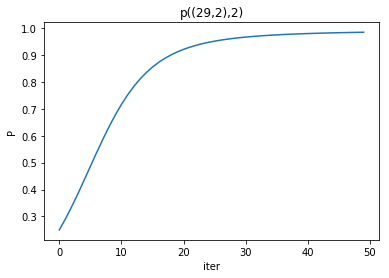

In [6]:
t_idx, s_idx = 0, 1
s, a = D_traj_states[t_idx][s_idx], D_traj_actions[t_idx][s_idx]
w_init = np.zeros((phi_s_dim, 1)).astype(np.float32) # Babes 2014 suggest to initialize w with 0s 
# np.random.uniform(0, 0.1, (phi_s_dim, 1)).astype(np.float32)
compute_V_init = lambda heap_fetures, w: np.zeros(heap_size, dtype=np.float32) #lambda heap_fetures, w: heap_fetures.dot(w).squeeze() 

with tf.Session(graph=g1) as sess:
    
    sess.run(tf.global_variables_initializer(), feed_dict={"w_init:0": w_init})
    writer = tf.summary.FileWriter('/var/tmp/rhirl/graphs', sess.graph)
    feed_dict = {"state_feature_tree:0": SFT_training[s], 
                 "action_idx:0": a,
                 "learning_rate:0": 0.1,
                 "pi_init:0": np.zeros((heap_size, nA), np.float32),
                 "v_init:0": compute_V_init(SFT_training[s][0], w_init)}
    
    p_vals = []
    for i in range(50):
        pi, v, _, w, grad, ugrad = sess.run(fetches=["pi_out:0", "v_out:0", "v_out_stack:0", "w_r:0", "grad_w_r:0", "update_w_r"], feed_dict=feed_dict)
        #print("Step: ", i, " Pi:", pi[0], "\n V:", v[0])
        feed_dict["v_init:0"] = compute_V_init(SFT_training[s][0], w)
        p_vals.append(pi[0, a])

writer.close()
plt.plot(p_vals), plt.title("p(({},{}),{})".format(s.x, s.y, a)), plt.xlabel("iter"), plt.ylabel("P")

#### RHIRL training

Model saved in path: /var/tmp/rhirl_model.ckpt
Total: 2637.2170448303223 ms, SFT compute: 1.1585190892219543 ms, Epoch time: 131.85991048812866 ms


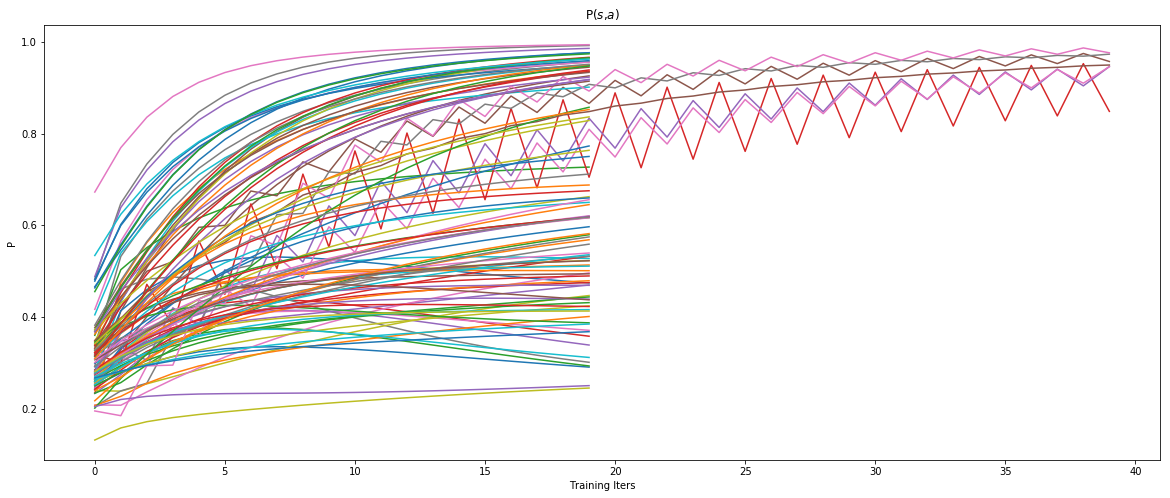

In [7]:
p_vals, w, time_state, time_epoch, time_total, _ = rhirl_train(SFT_training, phi_s_dim, heap_size, nA, D_traj_states, 
                                                            D_traj_actions, g1, saver, n_epochs=20, lr=0.1, verbose=False)
                                                            #run_rhc_callback=lambda w: run_rhc(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1))
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(time_total, time_state, time_epoch))
plot_p_vals_all_states(p_vals, D_traj_states, D_traj_actions, legend=False)

#### RHC on learned R

In [8]:
# cell_type_rewards = compute_cell_rewards(nvmdp, w[:5], nvmdp.feature_short_at_loc)
cell_rewards = compute_cell_rewards(nvmdp, w, phi_loc)
print("cell, true, obtained")
list(zip(nvmdp.cell_types, nvmdp.cell_type_rewards, [round(n,2) for n in np.eye(len(nvmdp.cell_types)).dot(w[:len(nvmdp.cell_types)])[:,0]]))

cell, true, obtained


[('white', 0, -1.23),
 ('yellow', 0, -1.89),
 ('red', -10.0, -8.34),
 ('lime', -10.0, -8.65),
 ('magenta', -10.0, -8.59)]

In [9]:
cell_values = compute_cell_values(nvmdp, SFT_full, heap_size, nA, w, g1)

In [10]:
rhc_traj_ss_train, rhc_traj_as_train, rhc_behavior_train = run_rhc_train(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1)
rhc_traj_ss_test, rhc_traj_as_test, rhc_behavior_test = run_rhc_test(nvmdp, 10, phi, H, heap_size, w, g1)

In [11]:
w

array([[  -1.2317748],
       [  -1.8908381],
       [  -8.335785 ],
       [  -8.652276 ],
       [  -8.592119 ],
       [   1.1676487],
       [  -4.776753 ],
       [   4.4650216],
       [  15.994157 ],
       [   5.990141 ],
       [-111.60071  ]], dtype=float32)

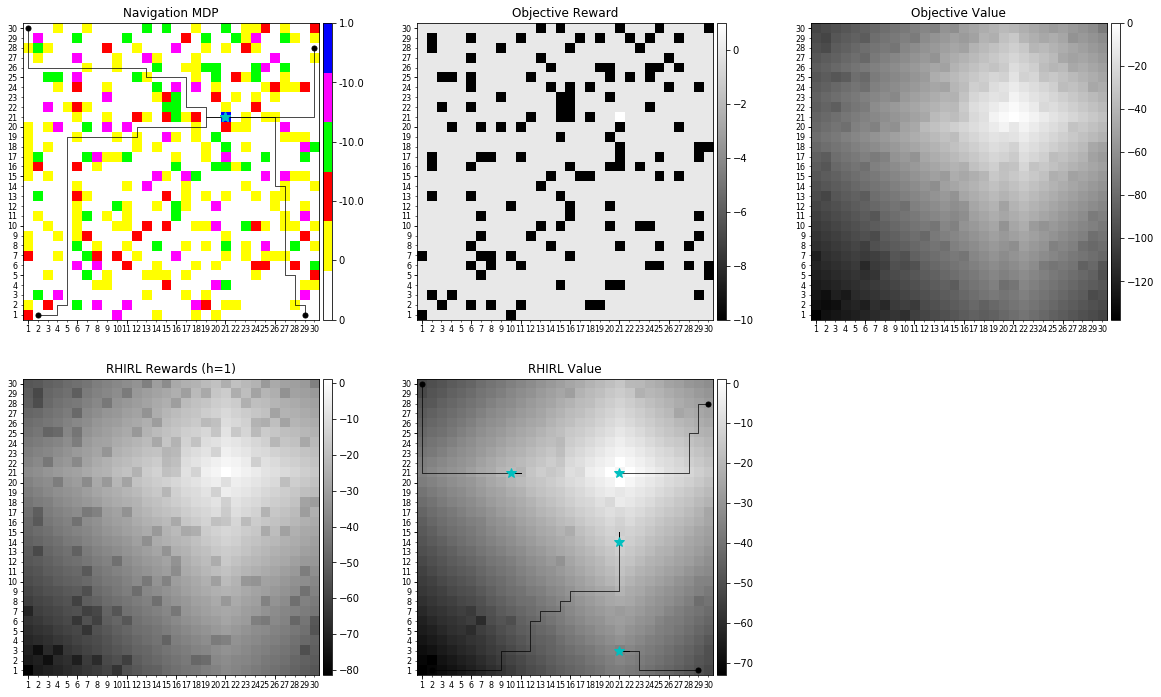

In [12]:
plt.figure(figsize=(20,12))
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="231", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="232", title="Objective Reward", new_fig=False)
nvmdp.visualize_grid(v_objective_map, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="233", new_fig=False, title="Objective Value")
# nvmdp.visualize_grid(cell_type_rewards, trajectories=None, 
#                cmap=plt.cm.gray, subplot_str="244", new_fig=False, title="RHIRL: Recovered Rewards (only cell type features)")
nvmdp.visualize_grid(cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="234", new_fig=False, title="RHIRL Rewards (h={})".format(H))
nvmdp.visualize_grid(cell_values, trajectories=rhc_traj_ss_train, 
               cmap=plt.cm.gray, subplot_str="235", new_fig=False, title="RHIRL Value")

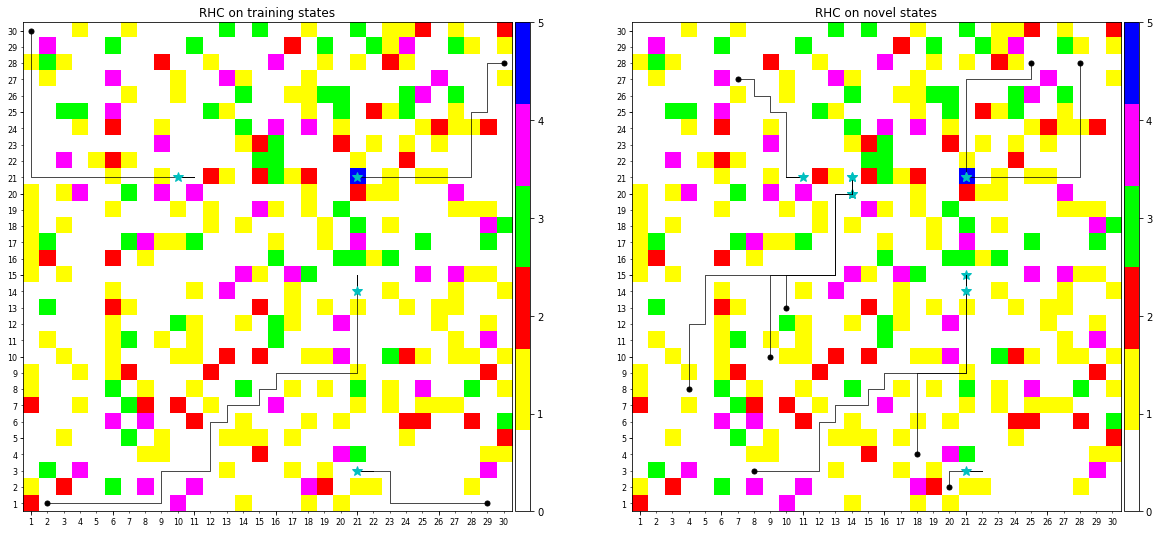

In [13]:
plt.figure(figsize=(20,12))
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_train, 
                   subplot_str="121", new_fig=False, title="RHC on training states")
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_test, 
                   subplot_str="122", new_fig=False, title="RHC on novel states")

#### H = 6
**State feature tree (SFT) heap**

In [14]:
gamma = 0.99
nA = len(nvmdp.actions)
H = 6
# phi = nvmdp.feature_short_at_state
# phi_loc = nvmdp.feature_short_at_loc
phi = nvmdp.feature_long_at_state
phi_loc = nvmdp.feature_long_at_loc

transition_fn = nvmdp.transition_func
actions = nvmdp.actions
phi_s_dim = len(phi(nvmdp.get_init_state()))

SFT_training, heap_size = get_training_data(D_traj_states, phi, transition_fn, actions, H)
g1, saver = build_rhirl_graph(heap_size, nA, phi_s_dim, gamma, H)
len(g1.get_operations())

442

In [15]:
SFT_full = compute_full_SFT(nvmdp, nA, phi, H)

#### RHIRL training

Model saved in path: /var/tmp/rhirl_model.ckpt
Total: 61335.30902862549 ms, SFT compute: 5.442858274493899 ms, Epoch time: 613.3520913124084 ms


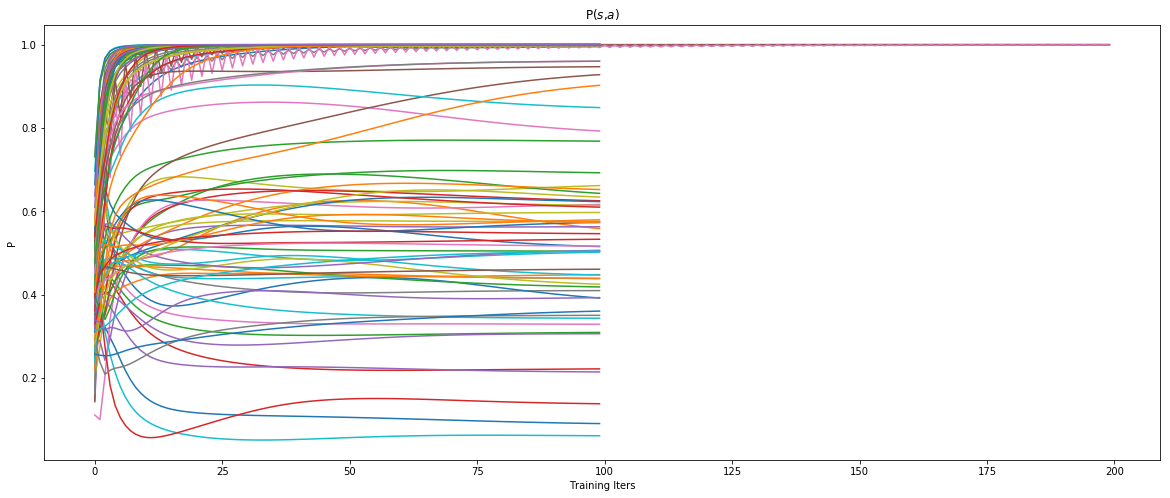

In [31]:
p_vals, w, time_state, time_epoch, time_total, _ = rhirl_train(SFT_training, phi_s_dim, heap_size, nA, D_traj_states, 
                                                            D_traj_actions, g1, saver, n_epochs=100, lr=0.1, verbose=False)
                                                            #run_rhc_callback=lambda w: run_rhc(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1))
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(time_total, time_state, time_epoch))
plot_p_vals_all_states(p_vals, D_traj_states, D_traj_actions, legend=False)

#### RHC on learned R

In [32]:
# cell_type_rewards = compute_cell_rewards(nvmdp, w[:5], nvmdp.feature_short_at_loc)
cell_rewards = compute_cell_rewards(nvmdp, w, phi_loc)
print("cell, true, obtained")
list(zip(nvmdp.cell_types, nvmdp.cell_type_rewards, [round(n,2) for n in np.eye(len(nvmdp.cell_types)).dot(w[:len(nvmdp.cell_types)])[:,0]]))

cell, true, obtained


[('white', 0, -1.45),
 ('yellow', 0, -2.64),
 ('red', -10.0, -8.98),
 ('lime', -10.0, -13.44),
 ('magenta', -10.0, -14.69)]

In [33]:
cell_values = compute_cell_values(nvmdp, SFT_full, heap_size, nA, w, g1)

In [34]:
rhc_traj_ss_train, rhc_traj_as_train, rhc_behavior_train = run_rhc_train(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1)
rhc_traj_ss_test, rhc_traj_as_test, rhc_behavior_test = run_rhc_test(nvmdp, 10, phi, H, heap_size, w, g1)

In [35]:
w

array([[  -1.4457293 ],
       [  -2.6416593 ],
       [  -8.976416  ],
       [ -13.44143   ],
       [ -14.69023   ],
       [   2.7518482 ],
       [   4.664663  ],
       [   3.6371374 ],
       [   6.0911913 ],
       [   0.96634245],
       [-104.28456   ]], dtype=float32)

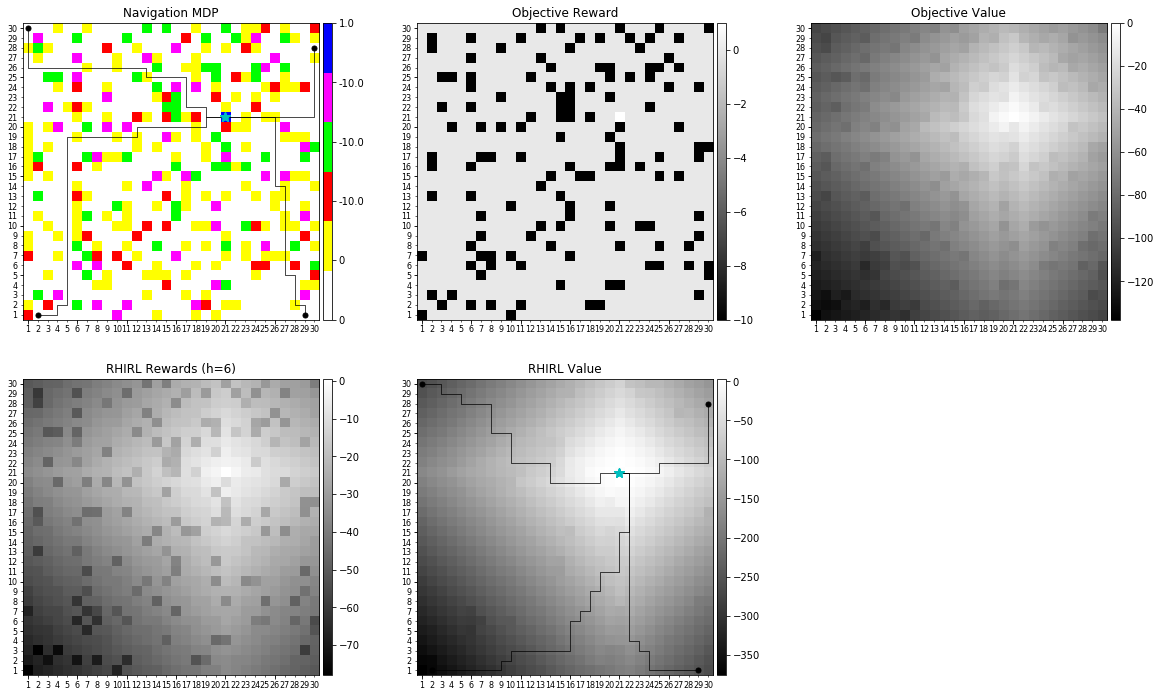

In [36]:
plt.figure(figsize=(20,12))
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="231", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="232", title="Objective Reward", new_fig=False)
nvmdp.visualize_grid(v_objective_map, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="233", new_fig=False, title="Objective Value")
# nvmdp.visualize_grid(cell_type_rewards, trajectories=None, 
#                cmap=plt.cm.gray, subplot_str="244", new_fig=False, title="RHIRL: Recovered Rewards (only cell type features)")
nvmdp.visualize_grid(cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="234", new_fig=False, title="RHIRL Rewards (h={})".format(H))
nvmdp.visualize_grid(cell_values, trajectories=rhc_traj_ss_train, 
               cmap=plt.cm.gray, subplot_str="235", new_fig=False, title="RHIRL Value")

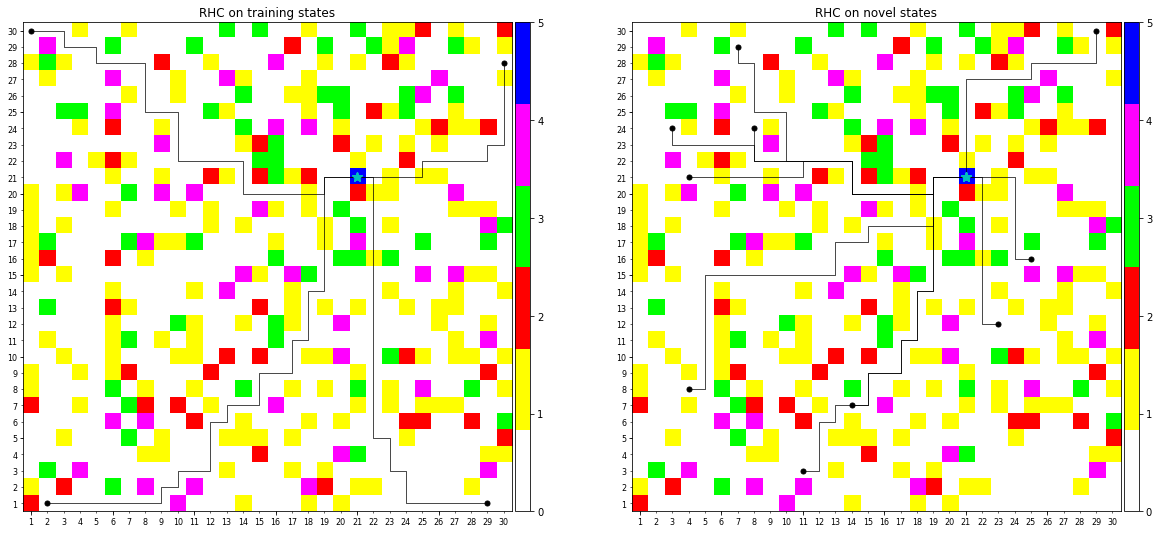

In [22]:
plt.figure(figsize=(20,12))
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_train, 
                   subplot_str="121", new_fig=False, title="RHC on training states")
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_test, 
                   subplot_str="122", new_fig=False, title="RHC on novel states")

## Reference  
[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.  
[2] Babes, Monica. Maximum Likelihood Inverse Reinforcement Learning (Doctoral dissertation). 2014.  

## Credits  
- Special thanks to Prof. Littman, Monica Vroman, and Jun Ki Lee for their invaluable inputs.  
- ComputeValue() TF implementation is inspired from Ivan Bogatyy's recursive neural network design: https://github.com/bogatyy/cs224d/tree/master/assignment3  
- David Abel. Simple RL: "A simple framework for experimenting with Reinforcement Learning in Python." Received from: https://github.com/david-abel/simple_rl.  